In [1]:
import torch
import pybullet
import numpy as np
from dynamics import *
from locomotion.envs.gym_envs import A1GymEnv
import matplotlib.pyplot as plt

In [2]:
# Create the robot environment
env = A1GymEnv(action_limit=(0.75, 0.75, 0.75), render=False, on_rack=False)
# Set lateral friction to 0.7
pybullet.changeDynamics(env._world_dict["ground"], -1, lateralFriction=0.7)
device = "cpu"
num_samples = 10
horizon = 10
# Init the NN dynamics model
dynamics = Dynamics(
    n_in=31,
    n_hidden=30,
    n_out=19,
    depth=20
)
dynamics.load_state_dict(torch.load("./logs/dynamics_20.pt"))

c:\Users\darsh\Desktop\model_based_locomotion\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [3]:
def MPC(dynamics, s0, env, horizon, num_samples, device):
    st = np.array([s0 for _ in range(num_samples)])
    a0 = np.array([env.action_space.sample() for _ in range(num_samples)])
    rt = torch.zeros(num_samples)
    for t in range(horizon):

        if t != 0:
            at = np.array([env.action_space.sample() for _ in range(num_samples)])
        else:
            at = a0

        X = np.concatenate((st, at), axis=1)
        X = torch.from_numpy(X).to(device).float()

        st_1 = dynamics(X).cpu().detach().numpy()
        rt += (st_1[:, 0] - st[:, 0])
        st = st_1
    idx = np.argmax(rt)
    return a0[idx]

In [4]:
dynamics.eval()
dynamics = dynamics.to(device)
rewards = []

st = env.reset()
for t in range(1000):
    at = MPC(
        dynamics,
        st,
        env,
        20,
        100,
        device=device
    )
    st_1, reward, done, info = env.step(at)
    rewards.append(reward)

    st = st_1

Text(0, 0.5, 'Reward')

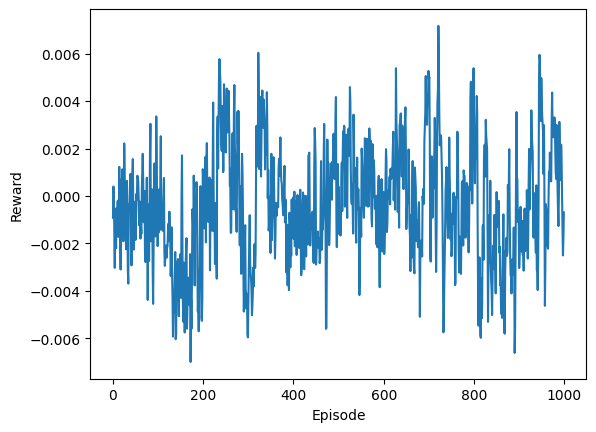

In [5]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")